#### Pattern Recognition in Financial Data

## Author: Adamantios Ntakaris

### Week 4 - Bayesian Linear Regression

##### Business School - University of Edinburgh 

In [1]:
# Install hdf5 library by interacting with the interpreter 
import sys
!{sys.executable} -m pip install hdf5storage
!{sys.executable} -m pip install tensorflow

# Import Libraries 
import hdf5storage
import pandas as pd
import keras
import tensorflow as tf

# Seminar 4
from scipy.stats import multivariate_normal
from scipy.stats import norm as univariate_normal
import numpy as np

You should consider upgrading via the '/Users/adamantios/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/adamantios/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
LOB_input = hdf5storage.loadmat('S092215-v50-AMZN_OCT2_states.mat')
LOB_Amazon = pd.DataFrame.from_dict(LOB_input['LOB'])

In [3]:
LOB_Amazon.head()

0        1      2        3    4        5    6        7    8   \
0  1442894410000        0      0        0    0  5427400  100        0    0   
1  1442894410000  5452100  49400  5476800  100  5427400  100        0    0   
2  1442894410073  5451900  49000  5476400  100  5427400  100  5476800  100   
3  1442894410073  5452000  48800  5476400  100  5427600  100  5476800  100   
4  1442894410073  5452000  48800  5476400  100  5427600  100  5476800  100   

        9   ...  33  34  35  36  37  38  39  40  41  42  
0        0  ...   0   0   0   0   0   0   0   0   0   0  
1        0  ...   0   0   0   0   0   0   0   0   0   0  
2        0  ...   0   0   0   0   0   0   0   0   0   0  
3  5427400  ...   0   0   0   0   0   0   0   0   0   0  
4        0  ...   0   0   0   0   0   0   0   0   0   0  

[5 rows x 43 columns]

In [4]:
# Add Column Titles
LOB_Amazon.columns = [
                      "Time", "Mid_Price", "Spread", 
                      "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1", # Level 1
                      "AskPrice2", "AskVolume2","BidPrice2", "BidVolume2", # Level 2
                      "AskPrice3", "AskVolume3","BidPrice3", "BidVolume3", # Level 3
                      "AskPrice4", "AskVolume4","BidPrice4", "BidVolume4", # Level 4
                      "AskPrice5", "AskVolume5","BidPrice5", "BidVolume5", # Level 5
                      "AskPrice6", "AskVolume6","BidPrice6", "BidVolume6", # Level 6
                      "AskPrice7", "AskVolume7","BidPrice7", "BidVolume7", # Level 7
                      "AskPrice8", "AskVolume8","BidPrice8", "BidVolume8", # Level 8
                      "AskPrice9", "AskVolume9","BidPrice9", "BidVolume9", # Level 9
                      "AskPrice10", "AskVolume10","BidPrice10", "BidVolume10", # Level 10
                     ]

In [5]:
LOB_Amazon.head()

Time  Mid_Price  Spread  AskPrice1  AskVolume1  BidPrice1  \
0  1442894410000          0       0          0           0    5427400   
1  1442894410000    5452100   49400    5476800         100    5427400   
2  1442894410073    5451900   49000    5476400         100    5427400   
3  1442894410073    5452000   48800    5476400         100    5427600   
4  1442894410073    5452000   48800    5476400         100    5427600   

   BidVolume1  AskPrice2  AskVolume2  BidPrice2  ...  BidPrice8  BidVolume8  \
0         100          0           0          0  ...          0           0   
1         100          0           0          0  ...          0           0   
2         100    5476800         100          0  ...          0           0   
3         100    5476800         100    5427400  ...          0           0   
4         100    5476800         100          0  ...          0           0   

   AskPrice9  AskVolume9  BidPrice9  BidVolume9  AskPrice10  AskVolume10  \
0          0           0          0           0           0            0   
1          0           0          0           0           0            0   
2          0           0          0           0           0            0   
3          0           0          0           0           0            0   
4          0           0          0           0           0            0   

   BidPrice10  BidVolume10  
0           0            0  
1           0            0  
2           0            0  
3           0            0  
4           0            0  

[5 rows x 43 columns]

In [6]:
# Identify the Columns that will be utilized as Inputs to the Regressors
features_lob = LOB_Amazon.iloc[100000:500000,4:5]
targets = LOB_Amazon['Mid_Price'].iloc[100000:500000]

features_num = np.array(features_lob)
features_flt = features_num.astype(float)

targets_num = np.array(targets)
targets_flt = targets_num.astype(float)

# Extarct Targets/Labels
print('Mid_Price_Series length:',len(targets))
print('Feature_Matrix length:', len(features_lob))

Mid_Price_Series length: 400000
Feature_Matrix length: 400000


In [7]:
features_lob.head(20)

AskVolume1
100000         150
100001         150
100002         150
100003         150
100004         150
100005         150
100006         150
100007         150
100008         150
100009         150
100010         150
100011         150
100012         150
100013         150
100014         150
100015         150
100016         150
100017         150
100018         150
100019         150

In [8]:

class BayesianLinearRegression:
    """ Bayesian linear regression
    
    Args:
        prior_mean: Mean values of the prior distribution (m_0)
        prior_cov: Covariance matrix of the prior distribution (S_0)
        noise_var: Variance of the noise distribution
    """
    
    def __init__(self, prior_mean: np.ndarray, prior_cov: np.ndarray, noise_var: float):
        self.prior_mean = prior_mean[:, np.newaxis] # column vector of shape (1, d)
        self.prior_cov = prior_cov # matrix of shape (d, d)
        # We initalize the prior distribution over the parameters using the given mean and covariance matrix
        # In the formulas above this corresponds to m_0 (prior_mean) and S_0 (prior_cov)
        self.prior = multivariate_normal(prior_mean, prior_cov)
        
        # We also know the variance of the noise
        self.noise_var = noise_var # single float value
        self.noise_precision = 1 / noise_var
        
        # Before performing any inference the parameter posterior equals the parameter prior
        self.param_posterior = self.prior
        # Accordingly, the posterior mean and covariance equal the prior mean and variance
        self.post_mean = self.prior_mean # corresponds to m_N in formulas
        self.post_cov = self.prior_cov # corresponds to S_N in formulas
        
    def update_posterior(self, features: np.ndarray, targets: np.ndarray):
        """
        Update the posterior distribution given new features and targets
        
        Args:
            features: numpy array of features
            targets: numpy array of targets
        """
        # Reshape targets to allow correct matrix multiplication
        # Input shape is (N,) but we need (N, 1)
        targets = targets[:, np.newaxis]
        
        # Compute the design matrix, shape (N, 2)
        design_matrix = self.compute_design_matrix(features)

        # Update the covariance matrix, shape (2, 2)
        design_matrix_dot_product = design_matrix.T.dot(design_matrix)
        #inv_prior_cov = np.linalg.inv(self.prior_cov)
        inv_prior_cov = np.linalg.pinv(self.prior_cov)

        
        #self.post_cov = np.linalg.inv(inv_prior_cov +  self.noise_precision * design_matrix_dot_product)
        self.post_cov = np.linalg.pinv(inv_prior_cov +  self.noise_precision * design_matrix_dot_product)

        
        # Update the mean, shape (2, 1)
        self.post_mean = self.post_cov.dot(inv_prior_cov.dot(self.prior_mean) + self.noise_precision * design_matrix.T.dot(targets))

        
        # Update the posterior distribution
        self.param_posterior = multivariate_normal(self.post_mean.flatten(), self.post_cov)
                
    def compute_design_matrix(self, features: np.ndarray) -> np.ndarray:
        """
        Compute the design matrix. To keep things simple we use simple linear
        regression and add the value phi_0 = 1 to our input data.
        
        Args:
            features: numpy array of features
        Returns:
            design_matrix: numpy array of transformed features
            
        >>> compute_design_matrix(np.array([2, 3]))
        np.array([[1., 2.], [1., 3.])
        """
        n_samples = len(features)
        phi_0 = np.ones(n_samples)
        design_matrix = np.column_stack((phi_0, features))
        return design_matrix
    
 
    def predict(self, features: np.ndarray):
        """
        Compute predictive posterior given new datapoint
        
        Args:
            features: 1d numpy array of features
        Returns:
            pred_posterior: predictive posterior distribution
        """
        design_matrix = self.compute_design_matrix(features)
        
        pred_mean = design_matrix.dot(self.post_mean)
        pred_cov = design_matrix.dot(self.post_cov.dot(design_matrix.T)) + self.noise_var
        
        pred_posterior = univariate_normal(pred_mean.flatten(), pred_cov)
        return pred_posterior

In [9]:
# Minimum Running Experiment - Synthetic Data 

# Step 1 
#
# Generate Synthetic Features and Labels

import matplotlib.pyplot as plt
%matplotlib inline

def compute_function_labels(slope: float, intercept: float, noise_std_dev: float, data: np.ndarray) -> np.ndarray:
    """
    Compute target values given function parameters and data.
    
    Args:
        slope: slope of the function (theta_1)
        intercept: intercept of the function (theta_0)
        data: input feature values (x)
        noise_std_dev: standard deviation of noise distribution (sigma)
        
    Returns:
        target values, either true or corrupted with noise
    """
    n_samples = len(data)
    if noise_std_dev == 0: # Real function
        return slope * data + intercept
    else: # Noise corrupted
        return slope * data + intercept + np.random.normal(0, noise_std_dev, n_samples) 
    
# Step 2 
#
# Generate the data

seed = 42
np.random.seed(seed)

#hyperparameters
n_datapoints = 1000
intercept = -0.7
slope = 0.9
noise_std_dev = 0.5
noise_var = noise_std_dev**2
lower_bound = -1.5
upper_bound = 1.5

features = np.random.uniform(lower_bound, upper_bound, n_datapoints)
labels = compute_function_labels(slope, intercept, 0., features)
noise_corrupted_labels = compute_function_labels(slope, intercept, noise_std_dev, features)

# Step 3
#
# Plot (not important)
plt.figure(figsize=(10,7))
plt.plot(features, labels, color='r', label="True values")
plt.scatter(features, noise_corrupted_labels, label="Noise corrupted values")
plt.xlabel("Features")
plt.ylabel("Labels")
plt.title("Real function along with noisy targets")
plt.legend();

In [10]:
# Step 4
#
# Initialize Bayesian Linear Regression Model

prior_mean = np.array([0, 0])
prior_cov = 1/2 * np.identity(2)
blr = BayesianLinearRegression(prior_mean, prior_cov, noise_var)

# Step 5
#
# Calculate and Update posterior over the Parameters
n_points_lst = [1, 5, 10, 50, 100, 200, 500, 1000]
previous_n_points = 0
for n_points in n_points_lst:
    train_features = features[previous_n_points:n_points]
    train_labels = noise_corrupted_labels[previous_n_points:n_points]
    blr.update_posterior(train_features, train_labels)
    
    previous_n_points = n_points
    
    
# Step 6
#
# Calculate predictive posterior per feature per test sample
import pandas as pd
import seaborn as sns

all_rows = []
sample_size = 1000
test_features = [-2, -1, 0, 1, 2]
all_labels = []

for feat in test_features:
    true_label = compute_function_labels(slope, intercept, 0, np.array([feat]))
    all_labels.append(true_label)
    pred_posterior = blr.predict(np.array([feat]))
    sample_predicted_labels = pred_posterior.rvs(size=sample_size)
    for label in sample_predicted_labels:
        all_rows.append([feat, label])
        
all_data = pd.DataFrame(all_rows, columns=["feature", "label"]) 
sns.displot(data=all_data, x="feature", y="label")
plt.scatter(x=test_features, y=all_labels, color="red", label="True values")
plt.title("Predictive posterior distributions")
plt.legend()
plt.plot();

In [11]:
# LOB Data

# Step 4
#
# Initialize Bayesian Linear Regression Model

noise_std_dev = 0.5
noise_var = noise_std_dev**2

prior_mean = np.array([0, 0])
prior_cov = 1/2 * np.identity(2)
blr = BayesianLinearRegression(prior_mean, prior_cov, noise_var)

# Step 5
#
# Calculate and Update posterior over the Parameters
n_points_lst = [1, 100, 1000, 10000, 100000, 400000]
previous_n_points = 0
for n_points in n_points_lst:
    train_features = features_flt[previous_n_points:n_points]
    train_labels = targets_flt[previous_n_points:n_points]
    blr.update_posterior(train_features, train_labels)
    
    previous_n_points = n_points

In [12]:
# Step 6
#
# Calculate predictive posterior per feature per test sample
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import seaborn as sns

all_rows = []
sample_size = 1000
test_features = LOB_Amazon.iloc[500000, 4:5]
all_labels = []

for feat in test_features:
    true_label = np.array([feat])
    all_labels.append(true_label)
    pred_posterior = blr.predict(np.array([feat]))
    sample_predicted_labels = pred_posterior.rvs(size=sample_size)
    for label in sample_predicted_labels:
        all_rows.append([feat, label])        

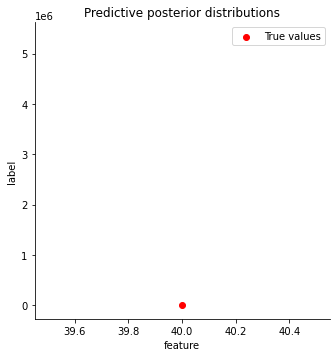

In [13]:
all_data = pd.DataFrame(all_rows, columns=["feature", "label"]) 
sns.displot(data=all_data, x="feature", y="label")
plt.scatter(x=np.array(test_features), y=all_labels, color="red", label="True values")
plt.title("Predictive posterior distributions")
plt.legend()
plt.plot();

# References

1. Pattern Recognition and Machine Learning, Chistopher Bishop
2. Mathematics for Machine Learning, Marc Peter Deisenroth, A.Aldo Faisal, and Cheng Soon Ong
3. Bayesian Linear Regression, Anna-Lena Popkes (link: https://alpopkes.com/posts/machine_learning/bayesian_linear_regression/)